In [2]:
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import cess_esp
from nltk.tag import UnigramTagger
from nltk.stem import WordNetLemmatizer
import pandas as pd
import string
import re

In [2]:
# Read the CSV file and create a DataFrame object
df = pd.read_csv("tweets_dialect_mix.csv")

# whitespaces
df['Location'] = df['Location'].str.strip()

# Replace cities with countries
df['Location'] = df['Location'].replace('Buenos Aires', 'Argentina')
df['Location'] = df['Location'].replace('Madrid', 'Spain')

# Print the updated DataFrame
df.head(-35)

,Tweet ID,Text,Location
0,1654499204243374082,Hola #Crunchyroll con motivo del cumple de #Go...,Argentina
1,1652705147850555392,Me enseñó que la confianza es lo más heavy que...,Argentina
2,1650141627627831298,Guay tiene el efecto Navarro... Lo de jugar a ...,Argentina
3,1649940473023283202,@ginlagatita Obvioooooo!! Las más guay bella ...,Argentina
4,1651406771834048515,Pichetto lleva la misma receta que De la Torre...,Argentina
...,...,...,...
336,1649832680203190277,@Santipatico_ Si este viejo de 36 pudo hacer a...,Spain
337,1649815684086415362,@agu5t1n4_ @Ezemoliina20 Si no te gusta que ot...,Spain
338,1649533861477351426,Te dedico “La Fórmula” de maluma y Marc y si e...,Spain
339,1649473058606809088,no me gusta estar enojada con vos\npedime perdón,Spain


In [3]:
def preprocess_dataframe(df):
    # Preprocess the text for each tweet in the DataFrame
    for i, row in df.iterrows():
        # Lowercase the text
        text = row['Text'].lower()

        # Remove punctuation from the text
        import string
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove URLs from the text
        #urls = re.findall(r'(?:https?://|www\.)\S+\.\S+', text)

        urls = re.findall(r'\bhttps\w+', text)

        # Tokenize the text into individual words
        words = word_tokenize(text)

        # Remove undesired characters from the list of words
        undesired_chars = ['@', '--', '#', ",", ".", "►", "''", "``","%","-","","/","_", "http","¿","¡","“","”","’"]
        
        words = [word for word in words if word not in undesired_chars]
        words = [word for word in words if word not in urls]


        # Join the list of words back into a single string
        text = " ".join(words)

        # Replace the original text with the preprocessed text in the output DataFrame
        df.at[i, 'Text'] = text

        # Delete rows with empty text
        if not text.strip():
            df = df.drop(i)

    return df

In [4]:
df = preprocess_dataframe(df)
df

,Tweet ID,Text,Location
0,1654499204243374082,hola crunchyroll con motivo del cumple de gon ...,Argentina
1,1652705147850555392,me enseñó que la confianza es lo más heavy que...,Argentina
2,1650141627627831298,guay tiene el efecto navarro lo de jugar a la ...,Argentina
3,1649940473023283202,ginlagatita obvioooooo las más guay bella y co...,Argentina
4,1651406771834048515,pichetto lleva la misma receta que de la torre...,Argentina
...,...,...,...
371,1645422694169554944,kinjorp a vos te quedaría pintado pero no creo...,Spain
372,1651176982892167169,brother siempre he querido tener una compu com...,Spain
373,1649090718173126656,en el trabajo hay una compu que es re lenta y ...,Spain
374,1646895519778652162,formateando mi compu blanca 👋,Spain


# Predict each instance of the Tweet-collection

In [39]:
import pandas as pd
from transformers import AutoTokenizer, DistilBertForSequenceClassification
import torch

# Load the pre-trained tokenizer and the BETO model
tokenizer = AutoTokenizer.from_pretrained("dccuchile/distilbert-base-spanish-uncased")
model = DistilBertForSequenceClassification.from_pretrained("./new_stuff/checkpoint-500")

# Create a new column for labels
df['label'] = ""

# Classify each sentence and predict corresponding label
for i, sentence in enumerate(df['Text']):
    # Check if the sentence is NaN
    if pd.isna(sentence):
        df.drop(i, inplace=True)  # Drop the row if 'Text' is NaN
        continue
    
    input_encoding = tokenizer(sentence, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**input_encoding)
        predictions = torch.argmax(outputs.logits, dim=-1)
        if predictions == 0:
            df.at[i, 'label'] = 'ARG'
        else:
            df.at[i, 'label'] = 'ES'

df



,Tweet ID,Text,Location,label
0,1654499204243374082,hola crunchyroll con motivo del cumple de gon ...,Argentina,ARG
1,1652705147850555392,me enseñó que la confianza es lo más heavy que...,Argentina,ES
2,1650141627627831298,guay tiene el efecto navarro lo de jugar a la ...,Argentina,ES
3,1649940473023283202,ginlagatita obvioooooo las más guay bella y co...,Argentina,ARG
4,1651406771834048515,pichetto lleva la misma receta que de la torre...,Argentina,ARG
...,...,...,...,...
371,1645422694169554944,kinjorp a vos te quedaría pintado pero no creo...,Spain,ARG
372,1651176982892167169,brother siempre he querido tener una compu com...,Spain,ARG
373,1649090718173126656,en el trabajo hay una compu que es re lenta y ...,Spain,ARG
374,1646895519778652162,formateando mi compu blanca 👋,Spain,ARG


In [40]:
def save_preprocessed_data(df, filename):
    df.to_csv(filename, index=False)
    
save_preprocessed_data(df, "tweets_mix_preprocessed.csv")

In [3]:
df = pd.read_csv("tweets_mix_preprocessed.csv")

# Word count

In [4]:
import pandas as pd
import nltk

nltk.download('punkt')

# Argentinian and Spanish expressions
argentinian_words = ['pibe', 'che','facherito', 'cheto', 'recontra',"boludo","sarpado", "chabón","vos","compu","sanguche"]
spanish_words = ['guay', 'cutre', 'chaval', 'ostia tio', 'cojones', "flipo", "hostia", "echar de menos","vosotros","ordenador","bocata"]

# Filter tweets by location
argentina_tweets = df[df['Location'].isin(['Argentina', 'Buenos Aires'])]
spain_tweets = df[df['Location'].isin(['Spain', 'Madrid'])]

# Tokenize each word and count word occurrences
argentina_word_counts = argentina_tweets['Text'].apply(lambda x: sum(word in argentinian_words for word in nltk.word_tokenize(x.lower()))).sum()
spain_word_counts = spain_tweets['Text'].apply(lambda x: sum(word in spanish_words for word in nltk.word_tokenize(x.lower()))).sum()

# Print word counts
print("Argentina Word Counts in Spain:")
for word in argentinian_words:
    count = spain_tweets['Text'].apply(lambda x: sum(word == w for w in nltk.word_tokenize(x.lower()))).sum()
    print(f"{word}: {count}")

print("\nSpain Word Counts in Argentina:")
for word in spanish_words:
    count = argentina_tweets['Text'].apply(lambda x: sum(word == w for w in nltk.word_tokenize(x.lower()))).sum()
    print(f"{word}: {count}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Argentina Word Counts in Spain:
pibe: 32
che: 52
facherito: 0
cheto: 6
recontra: 5
boludo: 12
sarpado: 0
chabón: 1
vos: 167
compu: 8
sanguche: 1

Spain Word Counts in Argentina:
guay: 4
cutre: 1
chaval: 9
ostia tio: 0
cojones: 24
flipo: 4
hostia: 9
echar de menos: 0
vosotros: 30
ordenador: 15
bocata: 0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


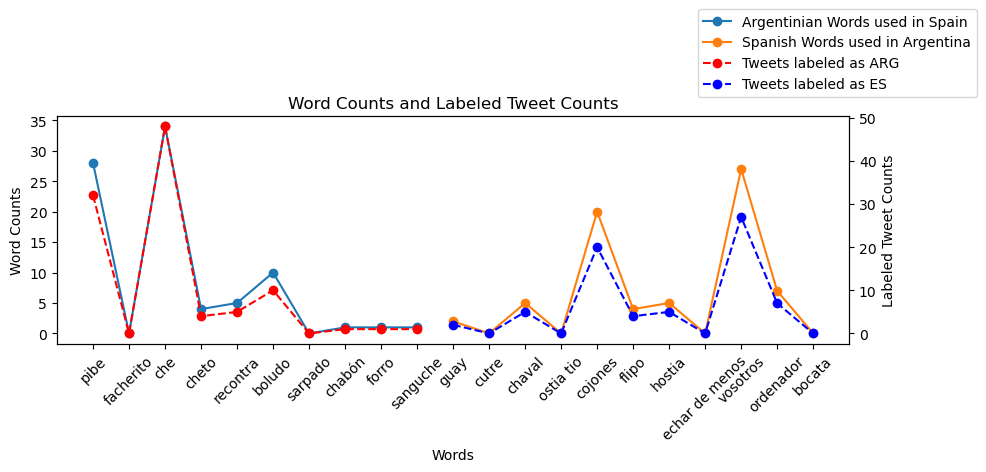

In [42]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')

# Argentinian and Spanish expressions
argentinian_words = ['pibe','facherito', "che",'cheto', 'recontra',"boludo","sarpado", "chabón","forro","sanguche"]
spanish_words = ['guay', 'cutre', 'chaval', 'ostia tio', 'cojones', "flipo", "hostia", "echar de menos","vosotros","ordenador","bocata"]

# tweets by location and label
argentina_spanish_tweets = df[(df['Location'] == 'Spain') & (df['label'] == 'ARG')]
spain_argentinian_tweets = df[(df['Location'] == 'Argentina') & (df['label'] == 'ES')]

# Calculate word counts
argentina_spanish_word_counts = [argentina_spanish_tweets['Text'].apply(lambda x: sum(word == w for w in nltk.word_tokenize(x.lower()))).sum() for word in argentinian_words]
spain_argentinian_word_counts = [spain_argentinian_tweets['Text'].apply(lambda x: sum(word == w for w in nltk.word_tokenize(x.lower()))).sum() for word in spanish_words]

# labeled tweet counts for words in Spain
argentina_spanish_labeled_counts = [max(argentina_spanish_tweets[argentina_spanish_tweets['Text'].str.contains(word)]['label'].value_counts().get('ARG', 0), count) for word, count in zip(argentinian_words, argentina_spanish_word_counts)]

# labeled tweet counts for words in Argentina
spain_argentinian_labeled_counts = [max(spain_argentinian_tweets[spain_argentinian_tweets['Text'].str.contains(word)]['label'].value_counts().get('ES', 0), count) for word, count in zip(spanish_words, spain_argentinian_word_counts)]

# Plotting of the line chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(argentinian_words, argentina_spanish_word_counts, marker='o', label='Argentinian Words used in Spain')
ax.plot(spanish_words, spain_argentinian_word_counts, marker='o', label='Spanish Words used in Argentina')
ax.set_xlabel('Words')
ax.set_ylabel('Word Counts')
ax.set_title('Word Counts and Labeled Tweet Counts')
ax.tick_params(axis='x', rotation=45)

# Adding secondary y-axis for labeled tweet counts
ax2 = ax.twinx()
ax2.plot(argentinian_words, argentina_spanish_labeled_counts, linestyle='--', color='red', marker='o', label='Tweets labeled as ARG')
ax2.plot(spanish_words, spain_argentinian_labeled_counts, linestyle='--', color='blue', marker='o', label='Tweets labeled as ES')
ax2.set_ylabel('Labeled Tweet Counts')


# Adjust the legend to the right side
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines += lines2
labels += labels2
ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.8, 1.5))

plt.tight_layout()
plt.show()



# Sentences extracted containing expressions

In [6]:
import re

def print_sentences_with_word(input_word, dataset):
    sentences = dataset[dataset['Text'].str.contains(r'\b{}\b'.format(re.escape(input_word)), case=False, regex=True)]

    # Print the complete sentences containing the selected words in the extracted collection
    for index, row in sentences.iterrows():
        sentence = row['Text']
        location = row['Location']
        label = row['label']
        print(f"Sentence: {sentence}")
        print(f"Location: {location}")
        print(f"Label: {label}")
        print("-------------------")

print_sentences_with_word("cojones", df)


Sentence: florcit0 son unos salchichas manipuladores sin cojones a ver hablando en serio los buenos empleados que quieran hacer híbrido o remoto 100 se vana ir a otra empresa que se los permita se van a quedar con la escoria
Location: Argentina
Label: ES
-------------------
Sentence: disen ser buenos y resultan gusanos ami sin cojones que tu seas fulano👹
Location: Argentina
Label: ES
-------------------
Sentence: linasproused carol52675519 eduaguirre7 tiene más cojones que él hasta salió a felicitar a la fifa por su mundial
Location: Argentina
Label: ES
-------------------
Sentence: que cojones todavía yo te quiero
Location: Argentina
Label: ES
-------------------
Sentence: pa qué cojones sirve arrepentirse
Location: Argentina
Label: ES
-------------------
Sentence: conseguirá apoyo del electorado si ganase podría hacer una buena gestión no es cuestión solamente de imagen física o carisma sino de cojones
Location: Argentina
Label: ES
-------------------
Sentence: ustedes tienen cojones